In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
import tensorflow_docs.plots
import tensorflow_docs.modeling
import tensorflow_docs as tfdocs

print(tf.__version__)

2.1.0


## Grab and parse the data

In [2]:
raw_dataset = pd.read_csv("4.14.20_corona_data.csv", sep=",", skipinitialspace=True)
raw_dataset = raw_dataset[["Total Count Confirmed", "Total Count Deaths"]]
dataset = raw_dataset.copy()

In [3]:
dataset.isna().sum()

Total Count Confirmed    0
Total Count Deaths       0
dtype: int64

In [4]:
dataset = dataset.dropna()
dataset.head()

,Total Count Confirmed,Total Count Deaths
0,0,0
1,0,0
2,0,0
3,0,0
4,2,0


In [5]:
dataset.tail()

,Total Count Confirmed,Total Count Deaths
79,21077,583
80,21702,605
81,22787,641
82,23931,715
83,24424,821


## Split the data into training set and testing set
We are only taking about 80% of the data into the training dataset, because if we use the complete set, the computer will recognize the pattern and the training dataset will be exactly the same as the testing dataset

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspecting the elements and their statistics

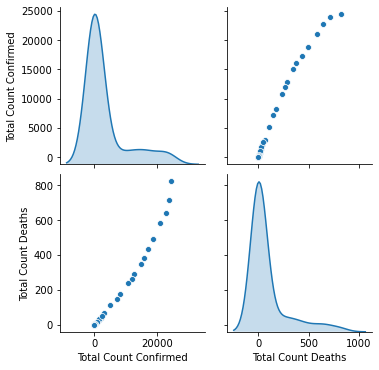

In [7]:
sns.pairplot(train_dataset[["Total Count Confirmed", "Total Count Deaths"]], diag_kind="kde")

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("Total Count Confirmed")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Total Count Deaths,67.0,88.343284,190.359353,0.0,0.0,0.0,34.5,821.0


In [9]:
train_labels = train_dataset.pop('Total Count Confirmed') # Will train this 'y'
test_labels = test_dataset.pop('Total Count Confirmed') # Our test 'y' we will use to compare with

## Normalize the data 

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Building the model
Building a Sequential model with two dense connectred hidden layers, and an output layer that holds a single, continous value. Created the build_moel function because we'll create a second model later on for optimization


In [11]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


## Training the model for 2000 epochs, and record the training and validation accuracies in the history object

In [31]:
EPOCHS = 2000
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])




Epoch: 0, loss:1141221.4988,  mae:679.7467,  mse:1141221.5000,  val_loss:676829.4375,  val_mae:621.8241,  val_mse:676829.4375,  
....................................................................................................
Epoch: 100, loss:1126335.0295,  mae:621.0751,  mse:1126335.0000,  val_loss:665291.5625,  val_mae:558.2231,  val_mse:665291.5625,  
....................................................................................................
Epoch: 200, loss:1125568.9340,  mae:623.1954,  mse:1125568.8750,  val_loss:621787.8750,  val_mae:539.1982,  val_mse:621787.8750,  
....................................................................................................
Epoch: 300, loss:1119774.8154,  mae:615.1581,  mse:1119774.7500,  val_loss:645823.5625,  val_mae:545.6967,  val_mse:645823.5625,  
....................................................................................................
Epoch: 400, loss:1114179.6148,  mae:617.8765,  mse:1114179.6250,  val_los

Text(0, 0.5, 'MAE [Total Count Confirmed]')

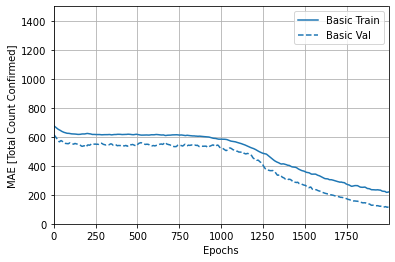

In [32]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 1500])
plt.ylabel('MAE [Total Count Confirmed]')

Text(0, 0.5, 'MAE [Total Count Confirmed]')

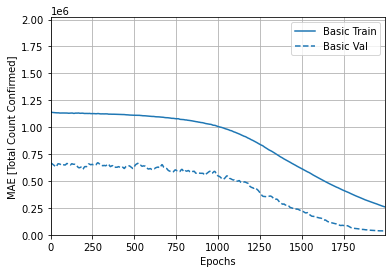

In [41]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 2020000])
plt.ylabel('MAE [Total Count Confirmed]')

## We can retrain the model to automatically stop training when the validation scores do not improve.

In [42]:
model = build_model()
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_history = model.fit(normed_train_data, train_labels,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:50037530.6415,  mae:3246.5813,  mse:50037528.0000,  val_loss:86360240.0000,  val_mae:4215.2642,  val_mse:86360240.0000,  
....................................................................................................
Epoch: 100, loss:49627787.3962,  mae:3232.5867,  mse:49627788.0000,  val_loss:85640768.0000,  val_mae:4197.3672,  val_mse:85640768.0000,  
....................................................................................................
Epoch: 200, loss:47928149.4340,  mae:3201.7170,  mse:47928152.0000,  val_loss:82763320.0000,  val_mae:4155.2993,  val_mse:82763320.0000,  
....................................................................................................
Epoch: 300, loss:43900647.5849,  mae:3134.6409,  mse:43900648.0000,  val_loss:75882792.0000,  val_mae:4056.3750,  val_mse:75882792.0000,  
....................................................................................................
Epoch: 400, loss:37152108.3774,  mae:3030

Text(0, 0.5, 'MAE [Total Count Confirmed]')

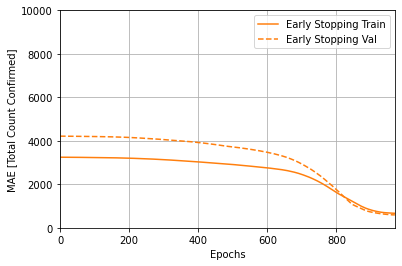

In [43]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10000])
plt.ylabel('MAE [Total Count Confirmed]')

## This tells how much we can expect the model to predict when we use it in the real worldd. This model generalizes by using the test set, which we didn't use when training the model

In [44]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} Total Count Confirmed".format(mae))

17/17 - 0s - loss: 446825.2500 - mae: 516.8166 - mse: 446825.2500
Testing set Mean Abs Error: 516.82 Total Count Confirmed


## Making the predictions using the data in the testing set

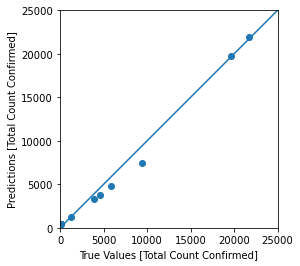

In [45]:
test_predictions = model.predict(normed_test_data).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Total Count Confirmed]')
plt.ylabel('Predictions [Total Count Confirmed]')
lims = [0, 25000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)